<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import pylab as pl
%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Task 1

In [2]:
#read data from github URL
grb = pd.read_csv('https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/main/HW1/grb050525A.csv')
print(grb.head())
print(grb.info())

#Investigate why/where mag has missing values
grb.loc[grb['mag'].isna()] #mag has missing values for observations 107-118 excepting 109.

  filter  time    mag  magerr  upperlimit
0      V    66  13.21    0.24           0
1      V    67  12.90    0.23           0
2      V    68  12.86    0.23           0
3      V    69  13.01    0.23           0
4      V    70  12.97    0.23           0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filter      119 non-null    object 
 1   time        119 non-null    int64  
 2   mag         108 non-null    float64
 3   magerr      119 non-null    float64
 4   upperlimit  119 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 4.8+ KB
None


,filter,time,mag,magerr,upperlimit
107,B,45468,NaN,20.70,1
108,V,49320,NaN,20.62,1
110,W1,52100,NaN,21.05,1
111,W2,52162,NaN,21.76,1
112,U,52994,NaN,19.68,1
113,B,62549,NaN,21.55,1
114,W1,63738,NaN,21.20,1
115,M2,74798,NaN,21.59,1
116,U,128928,NaN,20.05,1
117,V,971360,NaN,22.09,1


In [3]:
#Convert time to log-time
grb['logtime'] = np.log10(grb['time'])

findfont: Font family ['["sans-serif"]'] not found. Falling back to DejaVu Sans.


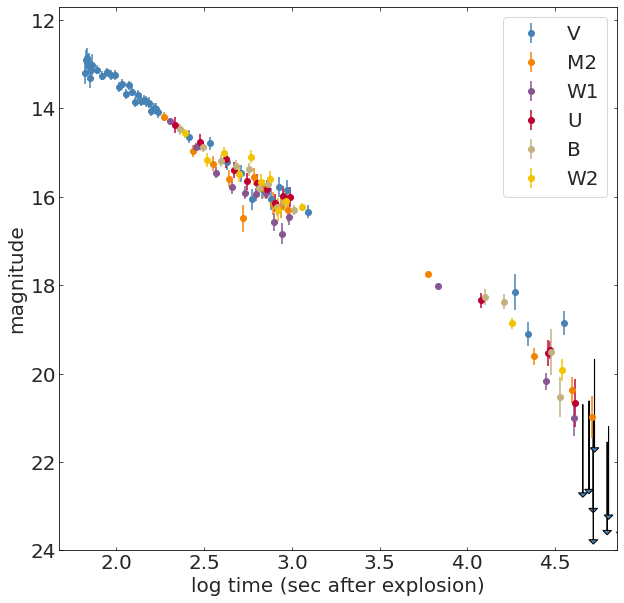

In [4]:
#copy pylab stylesheet from instructions
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

#Create figure and axis object
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#Set unique error-bar colors for each filter
for f in grb['filter'].unique():
  filter = grb.loc[grb['filter']==f]
  pl.errorbar(x=filter['logtime'],y=filter['mag'],yerr=filter['magerr'],
              fmt='o',label=f)

# plot the upperlimits as arrows 
for i in grb[grb.upperlimit == 1].index:
    pl.arrow(grb.loc[i].logtime, 
             grb.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')

#Invert y-axis since magnitude is on an inverse scale
pl.ylim(24,11.7)          
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A taken by the Swift satellite and obtained from Table 3 of Blustin et al. 2005. The photometric band for each datapoint is indicated by the legend. Upperlimits are inidicated by down-pointing arrows.

# Task 2a

In [9]:
#Remove data classified as 'upper limit' i.e. upperlimit == 1
grb = grb.loc[grb['upperlimit']==0]

#Set x as exogenous variable i.e. logtime
x = grb['logtime']

X = np.c_[np.ones((len(x),1)), x]

#Set y as endogenous variable i.e. mag
y = grb['mag']

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape, '\n')

#Calculate slope and intercept using normal equation
params = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(f'Best fit parameters from Normal Equation:\nIntercept: {params[0]}\nSlope: {params[1]}')

shape of the input array X (108, 2)
shape of the input array y (108,) 

Best fit parameters from Normal Equation:
Intercept: 8.582668233648741
Slope: 2.511999838500434


# Task 2b

In [6]:
#Calculate linear parameters using sklearn
lr = LinearRegression()
lr.fit(X, y)

print(f'Best-fit parameters from Sklearn Linear Regression:\nIntercept: {lr.intercept_}\nSlope: {lr.coef_[1]}')

Best-fit parameters from Sklearn Linear Regression:
Intercept: 8.582668233648771
Slope: 2.511999838500421


# Task 2c

In [7]:
#define a function for our line of best-fit
def line(x, b, a):
  return a*x + b

#define function for L1 error
def l1(args, x, y):
  a, b = args
  return np.sum(np.abs(y - line(a, b, x)))

x = grb['logtime']
y = grb['mag']

init = (10,1) #initial guess

L1_solution = minimize(l1, init, args=(x,y))
print(L1_solution, '\n')
print(f'Best-fit parameters from L1 Regression:\nIntercept: {L1_solution.x[0]}\nSlope:{L1_solution.x[1]}')

      fun: 26.304340597340804
 hess_inv: array([[ 0.00759366, -0.01591281],
       [-0.01591281,  0.03413314]])
      jac: array([-1.95810866,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 271
      nit: 11
     njev: 66
   status: 2
  success: False
        x: array([2.64023314, 8.22681691]) 

Best-fit parameters from L1 Regression:
Intercept: 2.64023313590039
Slope:8.226816914942821


# Task 2d

In [8]:
#define chi-square function
def chi(args, x, y, s):
  a, b = args
  return np.sum((y - line(x, b, a))**2 /s)

s = grb['magerr'] #assign uncertainties

init=(10,1)

chi_solution = minimize(chi, init, args=(x, y, s))
print(chi_solution, '\n')
print(f'Best-fit parameters from Chi-Squared Regression:\nIntercept: {chi_solution.x[0]}\nSlope:{chi_solution.x[1]}')

      fun: 58.4983742894839
 hess_inv: array([[ 0.00139784, -0.00381294],
       [-0.00381294,  0.01113153]])
      jac: array([2.86102295e-06, 4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 32
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([2.49968626, 8.58159554]) 

Best-fit parameters from Chi-Squared Regression:
Intercept: 2.499686256481849
Slope:8.581595544582807


# Task 3

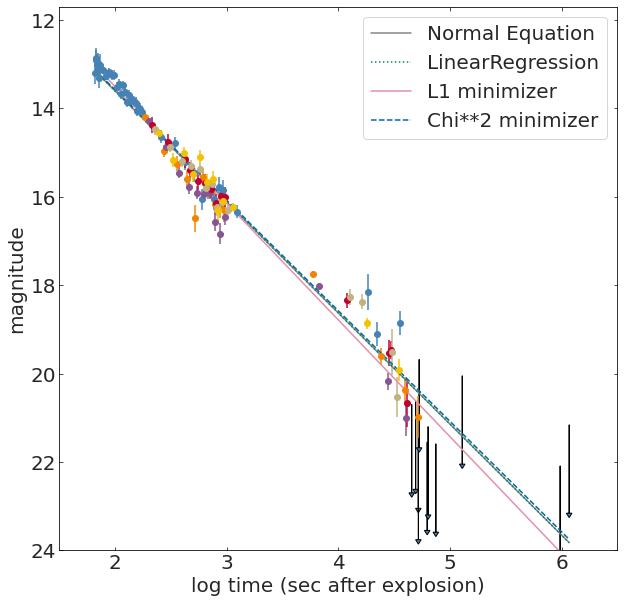

In [10]:
#restore grb to include upperlimits, not efficient but in this case it will do
grb = pd.read_csv('https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/main/HW1/grb050525A.csv')
grb['logtime'] = np.log10(grb['time'])

#Create figure and axis object
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#Set unique error-bar colors for each filter
for f in grb['filter'].unique():
  filter = grb.loc[grb['filter']==f]
  pl.errorbar(x=filter['logtime'],y=filter['mag'],yerr=filter['magerr'],
              fmt='o')

# plot the upperlimits as arrows 
for i in grb[grb.upperlimit == 1].index:
    pl.arrow(grb.loc[i].logtime, 
             grb.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
#define exogenous variable
x = grb['logtime']

#plot normal equation
ax.plot(x, line(x, params[0], params[1]), label='Normal Equation')

#plot linear regression
ax.plot(x, line(x, lr.intercept_, lr.coef_[1]), label='LinearRegression', ls=':')

#plot L1 optimization
ax.plot(x, line(x, L1_solution.x[1], L1_solution.x[0]), label='L1 minimizer', ls='-')

#plot Chi-Square optimization
ax.plot(x, line(x, chi_solution.x[1], chi_solution.x[0]), label='Chi**2 minimizer', ls='--')

pl.legend()

#Invert y-axis since magnitude is on an inverse scale
pl.ylim(24,11.7)
pl.xlim(1.5, 6.5)          
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1, but the plots of linear regression models are included. How each model was generated is indicated by the legend. Note that 'LinearRegression' was generated using sklearn.LinearRegression().